In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [43]:
def gen_mask(Re):
    '''
    Generate mask for a given Reynolds number.
    The Borders are set to 1, the rest to 0.
    The 0 values are then encoded by the Re number (from 0 to 1, while the Re from 100 to 4000)
    '''
    mask = np.zeros((128, 128))
    encoded_Re = (Re - 100) / 3900
    mask[:, :] = encoded_Re
    mask[-1, :] = mask[:, 0] = mask[:, -1] = 1
    return mask

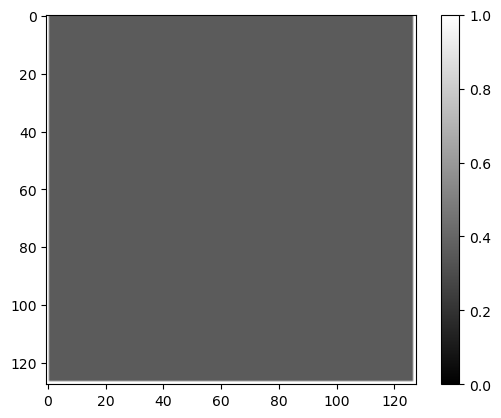

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
colorbar = cm.ScalarMappable(cmap='gray')
test = plt.imshow(gen_mask(1500), cmap='gray', vmin=0, vmax=1)
plt.colorbar(test, ax=ax)
plt.show()

In [45]:
from UNet import UNet
import utils

import os, sys, random, tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from UNet import UNet, weights_init
import dataset
import utils
import matplotlib.pyplot as plt

######## Settings ########
# learning rate, generator
lrG = 0.0006
# decay learning rate?
decayLr = True
# channel exponent to control network size
expo = 3
# data set config
prop=None # by default, use all from "../data/train"
#prop=[1000,0.75,0,0.25] # mix data from multiple directories
# save txt files with per epoch loss?
saveL1 = False

##########################

dropout    = 0.      # note, the original runs from https://arxiv.org/abs/1810.08217 used slight dropout, but the effect is minimal; conv layers "shouldn't need" dropout, hence set to 0 here.
doLoad     = "model"      # optional, path to pre-trained model

print("LR: {}".format(lrG))
print("LR decay: {}".format(decayLr))
print("Dropout: {}".format(dropout))

##########################

seed = random.randint(0, 2**32 - 1)
print("Random seed: {}".format(seed))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

######## Setup ########
print("\nSetting up model...")
model = UNet(channelExponent=expo, dropout=dropout)
if len(doLoad)>0:
    model.load_state_dict(torch.load(doLoad))
    print("Loaded model: "+doLoad + " successfully!")
    
# loss function
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lrG, betas=(0.5, 0.999), weight_decay=0.0)


LR: 0.0006
LR decay: True
Dropout: 0.0
Random seed: 4053742116

Setting up model...
Loaded model: model successfully!


In [52]:
# get a sample input
Re = 3550.
ts = 0.5

input_mask = dataset.gen_mask(Re, 128)
print("Input mask middle value: ", input_mask[64, 64])
input_u = dataset.open_image(f"../../data/{Re:.1f}/u_{ts:.2f}.png")
input_v = dataset.open_image(f"../../data/{Re:.1f}/v_{ts:.2f}.png")

input = np.stack([input_mask, input_u[0], input_v[0]], axis=0)
input = torch.from_numpy(input).float().unsqueeze(0)

target_p = dataset.open_image(f"../../data/{Re:.1f}/p_ss.png")
target_u = dataset.open_image(f"../../data/{Re:.1f}/u_ss.png")
target_v = dataset.open_image(f"../../data/{Re:.1f}/v_ss.png")

target = np.stack([target_p[0], target_u[0], target_v[0]], axis=0)
target = torch.from_numpy(target).float().unsqueeze(0)

# predict the output
output = model(input)
l1_loss = criterion(output, target)
print("L1 Loss: ", l1_loss.item())

print("Input shape: ", input[0].shape)
print("Output shape: ", output[0].shape)
print("Target shape: ", target[0].shape)

# plot the input and output
input_norm = utils.normalize(input[0].numpy()
target_norm = utils.normalize(target[0].numpy())
output_norm = utils.normalize(output[0].detach().numpy())

Input mask middle value:  0.88461536
L1 Loss:  36.50450897216797
Input shape:  torch.Size([3, 128, 128])
Output shape:  torch.Size([3, 128, 128])
Target shape:  torch.Size([3, 128, 128])


In [56]:
input_mask = input[0]

In [55]:
# remap the input to the original Re number
original_input_mask = input_mask * 3900 + 100
middle = len(original_input_mask) // 2
original_Re = original_input_mask[middle, middle]
print("Original Re: ", original_Re)

Original Re:  113.52941


In [51]:
(3550 - 100) / 3900

0.8846153846153846